In [12]:
#Load Data and Setup

import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
from multiprocessing import Pool, cpu_count
import functools

# Configuration
base_path = r"D:\Data 255\yolo_training\Tire train scaling test"
use_log_scale = False  # Set to True to use logarithmic scale for x-axis
num_processes = 5  # Number of processes to use

# Get target display name from the first subfolder
subfolders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
target_display_name = subfolders[0].split('_')[0] if subfolders else None
print(f"Target class: {target_display_name}")

# Load and preprocess data
print("Loading and preprocessing data...")
class_descriptions_df = pd.read_csv("oidv7-class-descriptions-boxable.csv")

# Find target LabelNames
target_labels = class_descriptions_df[class_descriptions_df['DisplayName'] == target_display_name]['LabelName'].tolist()
print(f"Found {len(target_labels)} matching label(s) for {target_display_name}")

# Load annotations with filtering
print("Loading and filtering annotations...")
annotations_df = pd.read_csv("oidv6-train-annotations-bbox.csv")
filtered_annotations = annotations_df[annotations_df['LabelName'].isin(target_labels)][['ImageID', 'LabelName']]
filtered_annotations = filtered_annotations.drop_duplicates('ImageID')
print("Data loaded and preprocessed successfully!")

import time
from concurrent.futures import ProcessPoolExecutor
import concurrent

def find_results_csv(base_path):
    """
    Recursively find all results.csv files in the directory structure
    """
    t0 = time.time()
    files = glob.glob(os.path.join(base_path, '**', 'results.csv'), recursive=True)
    print(f"Found {len(files)} CSV files in {time.time() - t0:.2f} seconds")
    return files

def extract_num_boxes(folder_name):
    """
    Extract the number of boxes from the folder name
    """
    parts = folder_name.split('_')
    for part in parts:
        if part.isdigit():
            return int(part)
    return None

def process_single_run(csv_file):
    """
    Process a single training run without multiprocessing
    """
    try:
        # Get folder information
        parent_folder = os.path.basename(os.path.dirname(os.path.dirname(csv_file)))
        run_path = os.path.dirname(os.path.dirname(csv_file))
        num_boxes = extract_num_boxes(parent_folder)
        
        if num_boxes is None:
            return None
            
        # Read the CSV and get best mAP
        df = pd.read_csv(csv_file, usecols=['epoch', 'metrics/mAP50(B)'])
        filtered_df = df[df['epoch'] > 10]
        best_map = filtered_df['metrics/mAP50(B)'].max()
        
        # Count images
        image_dir = os.path.join(run_path, 'dataset', 'train', 'images')
        image_files = glob.glob(os.path.join(image_dir, '*.*'))
        image_ids = {os.path.splitext(os.path.basename(f))[0] for f in image_files}
        num_images = len(image_ids.intersection(set(filtered_annotations['ImageID'])))
        
        return {
            'num_boxes': num_boxes,
            'num_images': num_images,
            'best_map50': best_map
        }
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")
        return None

def analyze_training_results(base_path):
    # Find all results.csv files
    csv_files = find_results_csv(base_path)
    
    # Process all runs
    t0 = time.time()
    print("Processing runs sequentially...")
    
    results_data = []
    for i, csv_file in enumerate(csv_files, 1):
        print(f"Processing run {i}/{len(csv_files)}...")
        result = process_single_run(csv_file)
        if result is not None:
            results_data.append(result)
    
    print(f"Processed all runs in {time.time() - t0:.2f} seconds")
    
    # Convert to DataFrame and sort by num_boxes
    results_df = pd.DataFrame(results_data)
    results_df = results_df.sort_values('num_boxes')
    
    return results_df

def plot_results(results_df, metric='num_boxes', use_log_scale=False, plot_title=""):
    # Create the plot
    plt.plot(results_df[metric], results_df['best_map50'], 
             marker='o', linestyle='-', linewidth=2, markersize=8)
    
    # Set x-axis scale based on parameter
    if use_log_scale:
        plt.xscale('log')
        xlabel = f'Number of {"Training Images" if metric == "num_images" else "Training Bounding Boxes"} (log scale)'
    else:
        xlabel = f'Number of {"Training Images" if metric == "num_images" else "Training Bounding Boxes"}'
    
    plt.xlabel(xlabel)
    plt.ylabel('Best mAP@50')
    plt.title(plot_title)
    
    # Add points annotations
    for idx, row in results_df.iterrows():
        plt.annotate(f'{row["best_map50"]:.3f}', 
                    (row[metric], row['best_map50']),
                    xytext=(5, 5), textcoords='offset points')


Target class: Tire
Loading and preprocessing data...
Found 1 matching label(s) for Tire
Loading and filtering annotations...
Data loaded and preprocessed successfully!


In [13]:
# Time the entire analysis
t_start = time.time()

# Analyze results
results_df = analyze_training_results(base_path)

print(f"\nTotal analysis time: {time.time() - t_start:.2f} seconds")

# Print tabular results
print("\nResults Summary:")
print(results_df.to_string(index=False))

Found 12 CSV files in 0.50 seconds
Processing runs sequentially...
Processing run 1/12...
Processing run 2/12...
Processing run 3/12...
Processing run 4/12...
Processing run 5/12...
Processing run 6/12...
Processing run 7/12...
Processing run 8/12...
Processing run 9/12...
Processing run 10/12...
Processing run 11/12...
Processing run 12/12...
Processed all runs in 0.13 seconds

Total analysis time: 0.63 seconds

Results Summary:
 num_boxes  num_images  best_map50
       100           2     0.09299
       300           6     0.20705
       500          10     0.33451
       750          15     0.22872
      1000          22     0.30427
      1500          37     0.30234
      2000          54     0.44085
      3000          91     0.49050
      5000         177     0.50948
     10000         450     0.56415
     15000         783     0.61829
     30000        2096     0.68223



Results Summary:
 num_boxes  num_images  best_map50
       100           2     0.09299
       300           6     0.20705
       500          10     0.33451
       750          15     0.22872
      1000          22     0.30427
      1500          37     0.30234
      2000          54     0.44085
      3000          91     0.49050
      5000         177     0.50948
     10000         450     0.56415
     15000         783     0.61829
     30000        2096     0.68223


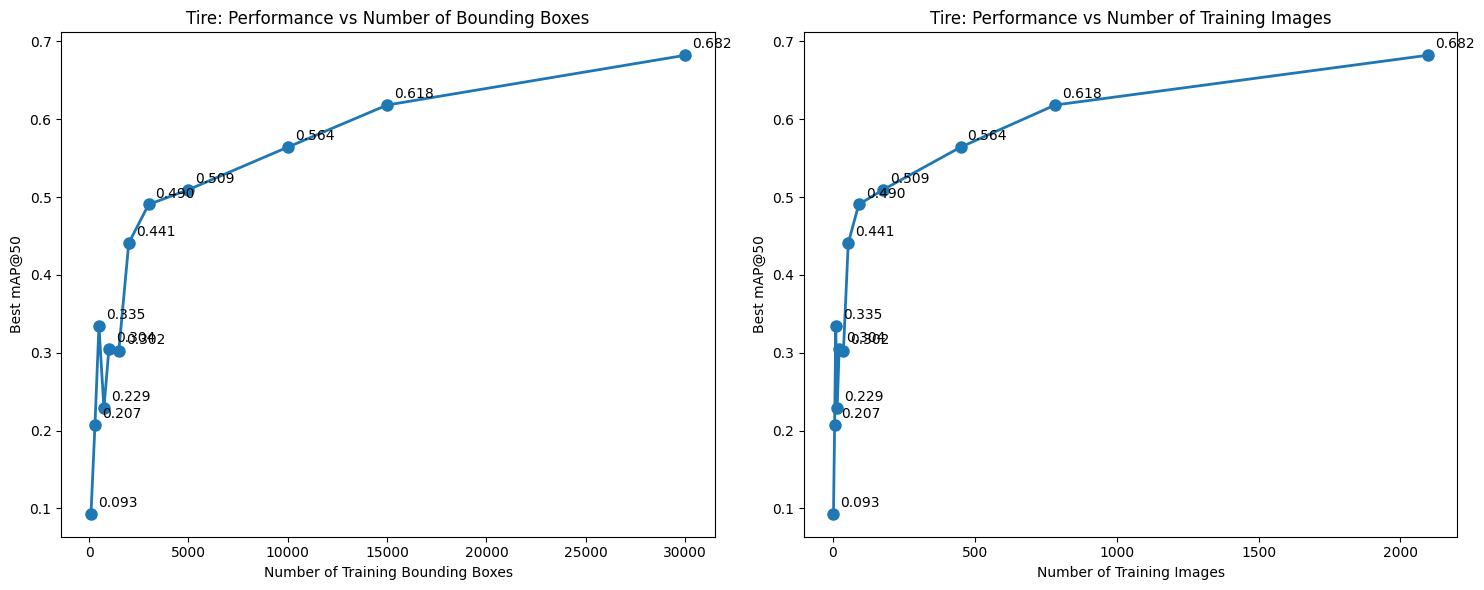

In [14]:
# Print tabular results
print("\nResults Summary:")
print(results_df.to_string(index=False))

# Create both plots side by side
plt.figure(figsize=(15, 6))

# Plot 1: mAP vs Boxes
plt.subplot(1, 2, 1)
plot_results(results_df, metric='num_boxes', use_log_scale=use_log_scale,
            plot_title="Tire: Performance vs Number of Bounding Boxes")

# Plot 2: mAP vs Images
plt.subplot(1, 2, 2)
plot_results(results_df, metric='num_images', use_log_scale=use_log_scale,
            plot_title="Tire: Performance vs Number of Training Images")

plt.tight_layout()
plt.show()